## Reading Data with DLTK
To build a reader you have to define a read function. This is a function with a signature `read_fn(file_references, mode, params=None)`, where 
- `file_references` is a array_like variable to be used to read files but can also be `None` if not used at all. 
- `mode` is a mode key from `tf.estimator.ModeKeys` and 
- `params` is a dictionary or `None` to pass additional parameters, you might need during interfacing with your inputs.

### Creating a custom python generator `read_fn`
In the following cell we define an example reader to read from the IXI dataset you can download with 
the included script. Let's start with some python, before we go into tensorflow:

In [1]:
import SimpleITK as sitk
import os
from dltk.io.augmentation import *
from dltk.io.preprocessing import *
import tensorflow as tf


def read_fn(file_references, mode, params=None):
    
    # We define a `read_fn` and iterate through the `file_references`, which
    # can contain information about the data to be read (e.g. a file path):
    for meta_data in file_references:
        
        # Here, we parse the `subject_id` to construct a file path to read
        # an image from.
        subject_id = meta_data[0]
        data_path = '../../data/IXI_HH/1mm'
        t1_fn = os.path.join(data_path, '{}/T1_1mm.nii.gz'.format(subject_id))
        
        # Read the .nii image containing a brain volume with SimpleITK and get 
        # the numpy array:
        sitk_t1 = sitk.ReadImage(t1_fn)
        t1 = sitk.GetArrayFromImage(sitk_t1)

        # Normalise the image to zero mean/unit std dev:
        t1 = whitening(t1)
        
        # Create a 4D Tensor with a dummy dimension for channels
        t1 = t1[..., np.newaxis]
        
        # If in PREDICT mode, yield the image (because there will be no label
        # present). Additionally, yield the sitk.Image pointer (including all
        # the header information) and some metadata (e.g. the subject id),
        # to facilitate post-processing (e.g. reslicing) and saving.
        # This can be useful when you want to use the same read function as 
        # python generator for deployment. Note: Data are not passed to
        # tensorflow if we do not specify a data type for them 
        # (c.f. `dltk/io/abstract_reader`):
        if mode == tf.estimator.ModeKeys.PREDICT:
            yield {'features': {'x': t1},
                   'metadata': {
                       'subject_id': subject_id,
                       'sitk': sitk_t1}}

        # Labels: Here, we parse the class *sex* from the file_references 
        # \in [1,2] and shift them to \in [0,1] for training:
        sex = np.int32(meta_data[1]) - 1
        y = sex
            
        # If in TRAIN mode, we want to augment the data to generalise better
        # and avoid overfitting to the training dataset:
        if mode == tf.estimator.ModeKeys.TRAIN:
            # Insert augmentation function here (see `dltk/io/augmentation`)
            pass
        
        # If training should be done on image patches for improved mixing, 
        # memory limitations or class balancing, call a patch extractor 
        # (see `dltk/io/augmentation`):
        if params['extract_examples']:
            images = extract_random_example_array(
                t1,
                example_size=params['example_size'],
                n_examples=params['n_examples'])
            
            # Loop the extracted image patches and yield
            for e in range(params['n_examples']):
                yield {'features': {'x': images[e].astype(np.float32)},
                       'labels': {'y': y.astype(np.int32)},
                       'metadata': {
                           'subject_id': subject_id,
                           'sitk': sitk_t1}}
                     
        # If desired (i.e. for evaluation, etc.), return the full images
        else:
            yield {'features': {'x': images},
                   'labels': {'y': y.astype(np.int32)},
                   'metadata': {
                       'subject_id': subject_id,
                       'sitk': sitk_t1}}

    return

The `read_fn` above can be used as generator in python but we wrap it for you with our `Reader` class.
For debugging, you can visualise the examples as follows:

In [2]:
# Use pandas to read csvs that hold meta information to read the files from disk
import pandas as pd
import tensorflow as tf


all_filenames = pd.read_csv(
    '../../data/IXI_HH/demographic_HH.csv',
    dtype=object,
    keep_default_na=False,
    na_values=[]).as_matrix()

# Set up a some parameters as required in the `read_fn`:
reader_params = {'n_examples': 1, 
                 'example_size': [128, 224, 224],
                 'extract_examples': True}

# Create a generator with the read file_references `all_filenames` and 
# `reader_params` in PREDICT mode:
it = read_fn(file_references=all_filenames,
             mode=tf.estimator.ModeKeys.PREDICT,
             params=reader_params)

# If you call `next`, the `read_fn` will yield an output dictionary as designed
# by you:
ex_dict = next(it)

# Print that output dict to debug
np.set_printoptions(edgeitems=1)
print(ex_dict)

{'features': {'x': array([[[[-0.7190699],
         ..., 
         [-0.7190699]],

        ..., 
        [[-0.7190699],
         ..., 
         [-0.7190699]]],


       ..., 
       [[[-0.7190699],
         ..., 
         [-0.7190699]],

        ..., 
        [[-0.7190699],
         ..., 
         [-0.7190699]]]], dtype=float32)}, 'metadata': {'subject_id': 'IXI012', 'sitk': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f35503893c0> >}}


### Using a custom `read_fn` with TensorFlow
In order to use the `read_fn` in a tensorflow graph, we wrap the generator to feed a Tensorflow Dataset. You can generate this queue using `dltk/io/abstract_reader` or do it manually:

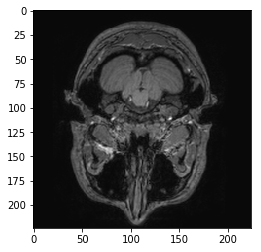

In [3]:
# As before, define the desired shapes of the examples and parameters to 
# pass to your `read_fn`:
reader_example_shapes = {'features': {'x': reader_params['example_size'] + [1,]},
                         'labels': {'y': []}}

reader_params = {'n_examples': 1,
                 'example_size': [128, 224, 224],
                 'extract_examples': True}

# If data_types are set for output dictionary entries, the `dltk/io/abstract_reader`
# creates a tensorflow queue and enqueues the respective outputs for training.
# Here, we would like to train our features and use labels as targets: 
reader_example_dtypes = {'features': {'x': tf.float32},
                         'labels': {'y': tf.int32}}

# Import and create a dltk reader
from dltk.io.abstract_reader import Reader
reader = Reader(read_fn=read_fn,
                dtypes=reader_example_dtypes)

# Now, get the input function and queue initialisation hook to use in a `tf.Session` or 
# with `tf.Estimator`. `shuffle_cache_size` defines the capacity of the queue.
input_fn, qinit_hook = reader.get_inputs(all_filenames,
                                         tf.estimator.ModeKeys.TRAIN,
                                         example_shapes=reader_example_shapes,
                                         batch_size=4,
                                         shuffle_cache_size=10, 
                                         params=reader_params)

# The input function splits the dictionary of `read_fn` into `features` and `labels` to
# match the `tf.Estimator` input requirements. However, both are standard dictionaries.
features, labels = input_fn()

# Let's create a `tf.Session` and get a batch of features and corresponding labels:
s = tf.train.MonitoredTrainingSession(hooks=[qinit_hook])
batch_features, batch_labels = s.run([features, labels])

# We can visualise the `batch_features` using matplotlib.
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(batch_features['x'][0, 0, :, :, 0], 'gray')
plt.show()

### Additional information on `dltk.io.abstract_reader`:
DLTK uses Tensorflow's queueing options to efficiently pass data to the computational graph. Our setup makes use of the [tf.data](https://www.tensorflow.org/api_docs/python/tf/data) API that enables us to use TFs wrappers with [tf.data.Dataset.from_generator](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator). We still wrap this function for better stack traces and to provide input functions suitable for [tf.Estimator](https://www.tensorflow.org/api_docs/python/tf/estimator).

In [4]:
help(Reader)

Help on class Reader in module dltk.io.abstract_reader:

class Reader(__builtin__.object)
 |  Wrapper for dataset generation given a read function
 |  
 |  Methods defined here:
 |  
 |  __init__(self, read_fn, dtypes)
 |      Constructs a Reader instance
 |      
 |      Args:
 |          read_fn: Input function returning features which is a dictionary of
 |              string feature name to `Tensor` or `SparseTensor`. If it
 |              returns a tuple, first item is extracted as features.
 |              Prediction continues until `input_fn` raises an end-of-input
 |              exception (`OutOfRangeError` or `StopIteration`).
 |          dtypes:  A nested structure of tf.DType objects corresponding to
 |              each component of an element yielded by generator.
 |  
 |  get_inputs(self, file_references, mode, example_shapes=None, shuffle_cache_size=100, batch_size=4, params=None)
 |      Function to provide the input_fn for a tf.Estimator.
 |      
 |      Args:
 |    